# A first example
This is a first example of how to use lettuce.
A two dimensional Taylor Green vortex is initialized and simulated for 10000 steps. Afterwards the energy and the velocity field is plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

In [2]:
context = lt.Context(device=torch.device('cuda:0') if torch.cuda
                     .is_available() else torch.device('cpu'),
                     dtype=torch.float32)
flow = lt.TaylorGreenVortex2D(resolution=256, reynolds_number=100, 
                              mach_number=0.05,
                              stencil=lt.D2Q9(),
                              context=context)
collision = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu)
energyreporter = lt.ObservableReporter(lt.IncompressibleKineticEnergy(flow), interval=1000, out=None)
simulation = lt.Simulation(flow=flow, collision=collision, boundaries=[], 
                           reporter=[energyreporter])

/home/philipp/lettuce/lettuce/_context.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array, *args, **kwargs, device=self.device, dtype=self.dtype)


steps     time     IncompressibleKineticEnergy
Could not resolve native extension.
Installing Native module (/tmp/tmptqpxyxy5) ...


* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

## Run simulation

In [3]:
mlups = simulation(10000)
print("Performance in MLUPS:", mlups)

Performance in MLUPS: 341.6214652397561


## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(11, 3)


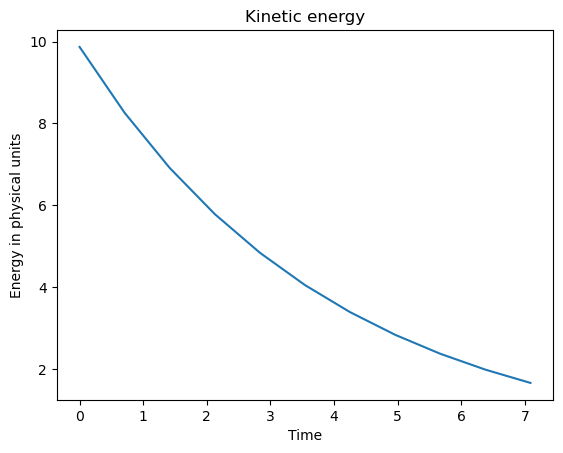

In [4]:
energy = np.array(simulation.reporter[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

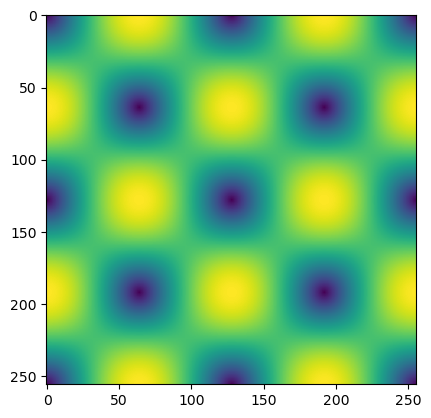

In [5]:
u = flow.u_pu.cpu().numpy()
u_norm = np.linalg.norm(u,axis=0)
plt.imshow(u_norm)
plt.show()